## Create 1D simulation of particles and calculate net magnetization

In [3]:
import numpy as np, matplotlib.pyplot as plt

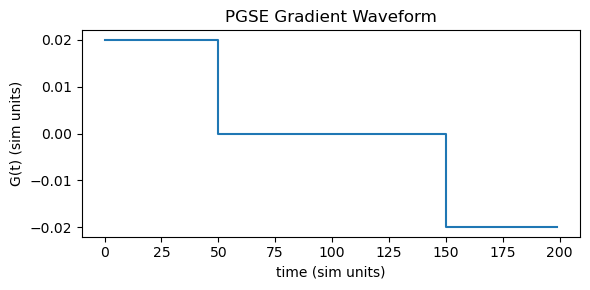

In [4]:
def make_pgse_gradient(dt=1.0, n_delta=50, n_gap=100, G_amp=0.02, gamma=1.0):
    """
    Create a simple PGSE gradient waveform:
    - +G_amp for n_delta steps
    - 0 for n_gap steps
    - -G_amp for n_delta steps

    Returns
    -------
    t        : (n_total,) time array
    G        : (n_total,) gradient array
    dt       : time step (sim units)
    delta    : pulse duration (sim time units)
    big_delta: time between leading edges of the two pulses (sim time units)
    gamma    : gyromagnetic ratio (sim units)
    """
    # Number of steps between leading edges of pulses:
    n_big_delta = n_delta + n_gap              # steps between pulse starts
    n_total = n_big_delta + n_delta           # total steps until end of 2nd pulse

    t = np.arange(n_total) * dt
    G = np.zeros(n_total)

    # First pulse: +G_amp from t=0 to t=n_delta*dt
    G[0:n_delta] = G_amp

    # Second pulse: -G_amp starting at t = n_big_delta*dt
    G[n_big_delta:n_big_delta + n_delta] = -G_amp

    delta = n_delta * dt              # duration of each pulse
    big_delta = n_big_delta * dt      # time between pulse starts (Δ)

    return t, G, dt, delta, big_delta, gamma

# Example: make and plot a gradient
t, G, dt, delta, big_delta, gamma = make_pgse_gradient()

plt.figure(figsize=(6, 3))
plt.step(t, G, where="post")
plt.xlabel("time (sim units)")
plt.ylabel("G(t) (sim units)")
plt.title("PGSE Gradient Waveform")
plt.tight_layout()
plt.show()

In [45]:
def simulate_diffusion_signal(
    D=0.001,          # diffusion coefficient in sim units
    n_spins=50000,    # number of random walkers
    G_amp=0.02,       # gradient amplitude (sim units)
    n_delta=50,
    n_gap=100,
    dt=1.0,
    gamma=1.0,
    seed=0,
    L=None
):
    """
    Simulate a PGSE diffusion experiment in 1D using Brownian motion.

    Returns
    -------
    S_sim      : complex, simulated signal (average magnetization)
    S_mag_sim  : float, |S_sim|
    S_ST       : float, Stejskal–Tanner predicted magnitude
    b_value    : float, b (sim units)
    t, G       : time array and gradient waveform
    """
    if seed is not None:
        np.random.seed(seed)

    # Build gradient waveform with given parameters
    t, G, dt, delta, big_delta, gamma = make_pgse_gradient(
        dt=dt, n_delta=n_delta, n_gap=n_gap, G_amp=G_amp, gamma=gamma
    )
    n_total = len(t)

    # Initialize positions and phases
    x = np.zeros(n_spins)      # all spins start at x=0
    phi = np.zeros(n_spins)    # accumulated phase

    # Precompute diffusion step scale
    # Brownian increments: dx ~ N(0, sqrt(2 * D * dt))
    step_sigma = np.sqrt(2 * D * dt)

    for k in range(n_total):
        # Diffusion step
        x += step_sigma * np.random.randn(n_spins)

        # optional reflecting walls
        if L is not None:
            left, right = -L/2, L/2 # [0,L], [-L, L], or [-L/2, L/2]
            x[x < left]  = -x[x < left]
            x[x > right] = 2*right - x[x > right]

        # Phase accumulation under gradient
        # Using x after the diffusion step (Euler-like); dt is our time step
        phi += gamma * G[k] * x * dt

    # Simulated signal: average transverse magnetization
    S_sim = np.mean(np.exp(1j * phi))
    S_mag_sim = np.abs(S_sim)

    # Stejskal–Tanner prediction: S/S0 = exp(-bD)
    # b = gamma^2 * G^2 * delta^2 * (Delta - delta/3)
    # Here Delta = big_delta (time between leading edges)
    b_value = (gamma**2) * (G_amp**2) * (delta**2) * (big_delta - delta/3.0)
    S_ST = np.exp(-b_value * D)

    return S_sim, S_mag_sim, S_ST, b_value, t, G, D, delta, big_delta

### Simulation values (first try)

In [6]:
# Example parameters (all in sim units)
D = 0.001           # "true" diffusion coefficient
G_amp = 0.03        # gradient strength
n_spins = 80000     # more spins -> less Monte Carlo noise
n_delta = 50
n_gap = 100
dt = 1.0
gamma = 1.0         # sim gyromagnetic ratio


S_sim, S_mag_sim, S_ST, b_value, t, G, D_used, delta, big_delta = simulate_diffusion_signal(
    D=D,
    n_spins=n_spins,
    G_amp=G_amp,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    seed=42
)

print(f"Simulation parameters (sim units):")
print(f"  D       = {D_used}")
print(f"  G_amp   = {G_amp}")
print(f"  delta   = {delta}")
print(f"  Delta   = {big_delta}")
print(f"  b       = {b_value}")
print()
print(f"Simulated complex signal S_sim = {S_sim}")
print(f"|S_sim| (sim)   = {S_mag_sim:.4f}")
print(f"|S_ST| (theory) = {S_ST:.4f}")
print(f"Relative error  = {(S_mag_sim - S_ST)/S_ST:.2%}")

Simulation parameters (sim units):
  D       = 0.001
  G_amp   = 0.03
  delta   = 50.0
  Delta   = 150.0
  b       = 300.0

Simulated complex signal S_sim = (0.7407098334417807+0.0003286816313608604j)
|S_sim| (sim)   = 0.7407
|S_ST| (theory) = 0.7408
Relative error  = -0.01%


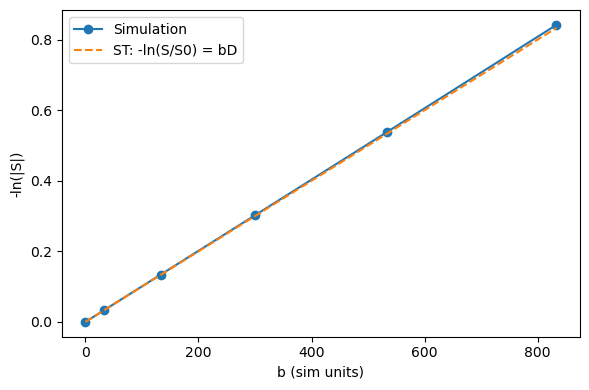

In [7]:
G_vals = np.linspace(0.0, 0.05, 6)   # 6 gradient amplitudes
sim_mags = []
st_mags = []
b_vals = []

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals)
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

plt.figure(figsize=(6,4))
plt.plot(b_vals, -np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, b_vals * D, "--", label="ST: -ln(S/S0) = bD")
plt.xlabel("b (sim units)")
plt.ylabel("-ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()

### Real physical values

In [9]:
# Example parameters (all in sim units)
D = 8e-9         # cm^2/ms
G_amp = 2.0      # Gauss/cm  
n_spins = 50000    # number of spin particles
n_delta = 300    # number of dt for pulse
n_gap = 200      # number of dt for gap. n_big_delta = n_spins + n_gap
dt = 0.1         # miliseconds, or 100 microseconds
gamma = 26.75      # rad/(ms*Gauss)


S_sim, S_mag_sim, S_ST, b_value, t, G, D_used, delta, big_delta = simulate_diffusion_signal(
    D=D,
    n_spins=n_spins,
    G_amp=G_amp,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    seed=42
)

print(f"Simulation parameters (real values):")
print(f"  D       = {D_used}")
print(f"  G_amp   = {G_amp}")
print(f"  delta   = {delta}")
print(f"  Delta   = {big_delta}")
print(f"  b       = {b_value}")
print()
print(f"Simulated complex signal S_sim = {S_sim}")
print(f"|S_sim| (sim)   = {S_mag_sim:.4f}")
print(f"|S_ST| (theory) = {S_ST:.4f}")
print(f"Relative error  = {(S_mag_sim - S_ST)/S_ST:.2%}")

Simulation parameters (real values):
  D       = 8e-09
  G_amp   = 2.0
  delta   = 30.0
  Delta   = 50.0
  b       = 103041000.0

Simulated complex signal S_sim = (0.4386981011849354+0.0018972893721443207j)
|S_sim| (sim)   = 0.4387
|S_ST| (theory) = 0.4385
Relative error  = 0.04%


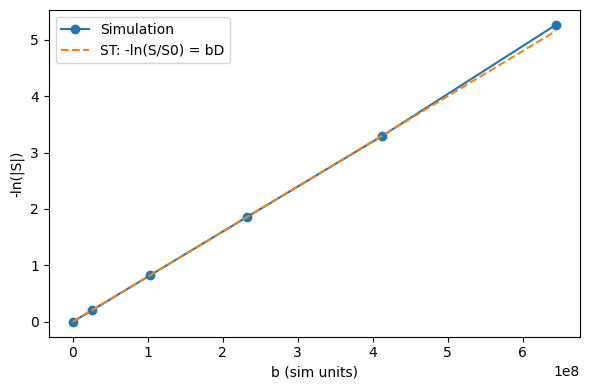

In [10]:
G_vals = np.linspace(0.0, 5.0, 6)   # 6 gradient amplitudes
sim_mags = []
st_mags = []
b_vals = []

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals)
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

plt.figure(figsize=(6,4))
plt.plot(b_vals, -np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, b_vals * D, "--", label="ST: -ln(S/S0) = bD")
plt.xlabel("b (sim units)")
plt.ylabel("-ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()

### Real physical values with restricted diffusion

In [46]:
D = 8e-9         # cm^2/ms
G_amp = 2.0      # Gauss/cm  
n_spins = 50000    # number of spin particles
n_delta = 300    # number of dt for pulse
n_gap = 200      # number of dt for gap. n_big_delta = n_spins + n_gap
dt = 0.1         # miliseconds, or 100 microseconds
gamma = 26.75      # rad/(ms*Gauss)
L = 0.004 # cm of space length, or equivalently 40 um, about size of a cell
cnv_fct = 1e-5 # convert ms/cm^2 to s/mm^2 for b-value

S_sim, S_mag_sim, S_ST, b_value, t, G, D_used, delta, big_delta = simulate_diffusion_signal(
    D=D,
    n_spins=n_spins,
    G_amp=G_amp,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    seed=42,
    L=L
)

print(f"Simulation parameters (real values):")
print(f"  D       = {D_used}")
print(f"  G_amp   = {G_amp}")
print(f"  delta   = {delta}")
print(f"  Delta   = {big_delta}")
print(f"  b       = {b_value}")
print()
print(f"Simulated complex signal S_sim = {S_sim}")
print(f"|S_sim| (sim)   = {S_mag_sim:.4f}")
print(f"|S_ST| (theory) = {S_ST:.4f}")
print(f"Relative error  = {(S_mag_sim - S_ST)/S_ST:.2%}")

Simulation parameters (real values):
  D       = 8e-09
  G_amp   = 2.0
  delta   = 30.0
  Delta   = 50.0
  b       = 103041000.0

Simulated complex signal S_sim = (0.48076206018697876-0.05708452809436431j)
|S_sim| (sim)   = 0.4841
|S_ST| (theory) = 0.4385
Relative error  = 10.40%


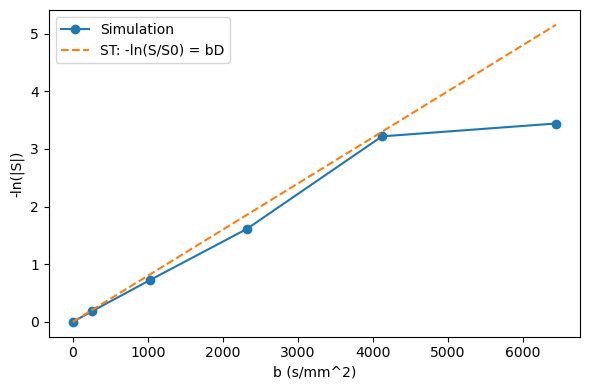

In [48]:
G_vals = np.linspace(0.0, 5.0, 6)   # 6 gradient amplitudes
sim_mags = []
st_mags = []
b_vals = []

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0, L = L
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals) * cnv_fct
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

plt.figure(figsize=(6,4))
plt.plot(b_vals, -np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, b_vals * D / cnv_fct, "--", label="ST: -ln(S/S0) = bD")
plt.xlabel("b (s/mm^2)")
plt.ylabel("-ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()